In [1]:
import numpy as np
import pandas as pd
import assist_function
import sys
sys.path.append("C://Users/Admin/Desktop/000-data_science/sem2-project_1/treepedia_dl_public-master")
import model_lib as treepedia_dl

# load model

In [2]:
def unsupervised_segmentation(images):
    red = images[:, :, :, 0]
    green = images[:, :, :, 1]
    blue = images[:, :, :, 2]

    diff_1 = green - red
    diff_2 = green - blue

    diff_1[diff_1 < 0] = 0
    diff_2[diff_2 < 0] = 0

    Diff = diff_1 * diff_2

    return Diff

In [3]:
def unsupervised_GVI_pred(images):
    red = images[:, :, :, 0]
    green = images[:, :, :, 1]
    blue = images[:, :, :, 2]

    diff_1 = green - red
    diff_2 = green - blue

    diff_1[diff_1 < 0] = 0
    diff_2[diff_2 < 0] = 0

    Diff = diff_1 * diff_2
    
    Diff[Diff < 30] = 0
    Diff[Diff >= 30] = 1
    unsupervised_GVI_pred =[]

    for i in range(len(Diff)):
        pred = np.mean(Diff[i] != 0)
        unsupervised_GVI_pred.append(pred)

    unsupervised_GVI_pred = np.array(unsupervised_GVI_pred)

    return unsupervised_GVI_pred

# load data

In [4]:
current_model = [224, 224, 3]

X_test, y_test = assist_function.load_and_resize(
    "data/input_data/labelled_pair_test.txt", current_model)

y_test[y_test < 100] = 0
y_test[y_test >= 100] = 1
y_test_GVI = np.mean(y_test, axis=(1,2))

In [5]:
test_metadata = assist_function.retrieve_metadata('data/input_data/labelled_pair_test.txt')
test_metadata.head(3)

,lat,lng,heading
0,1.464214838923537,103.7680466183046,120
1,1.45906910621281,103.7668877466677,180
2,1.463961299646011,103.7717313271459,180


# Inference

In [6]:
import time
st =  time.time()

pred_ts = unsupervised_GVI_pred(X_test.astype(float))   # need to change the type to float before proceeding
pred_ts

et =  time.time()
elapsed_time = et - st
print('training time = ', elapsed_time,'seconds')

training time =  0.15352916717529297 seconds


In [10]:
# compute difference between prediction and true GVI
diff = np.zeros([len(X_test), 1])
for i in range(len(X_test)):
    diff[i] = y_test_GVI[i]-pred_ts[i]

# evaluate accuracy of model
print("Average Absolute GVI error is: %f" % np.mean(np.abs(diff)))
percentile_result = np.percentile(diff, [5, 95])
print("5-95 percentile of Absolute GVI error is (%f, %f)" %
      (percentile_result[0], percentile_result[1]))
print("Correlation of predicted and true GVI is: %f" %
      np.corrcoef(pred_ts.T, y_test_GVI.T)[0, 1])

Average Absolute GVI error is: 0.067772
5-95 percentile of Absolute GVI error is (-0.065886, 0.198102)
Correlation of predicted and true GVI is: 0.944534


In [11]:
pixseg_prediction = pd.concat([test_metadata, pd.Series(pred_ts.flatten()), pd.Series(y_test_GVI)], 
                            axis=1)
pixseg_prediction = pixseg_prediction.rename(columns={0: 'pred', 1: 'gt'})
pixseg_prediction['diff'] = (pixseg_prediction['gt'] - pixseg_prediction['pred']).abs()
pixseg_prediction

,lat,lng,heading,pred,gt,diff
0,1.464214838923537,103.7680466183046,120,0.131099,0.141582,0.010483
1,1.45906910621281,103.7668877466677,180,0.059391,0.000000,0.059391
2,1.463961299646011,103.7717313271459,180,0.217734,0.197325,0.020408
3,1.467388080645603,103.7654123835077,0,0.088987,0.040079,0.048908
4,1.46385196757463,103.7714928793899,180,0.106884,0.000000,0.106884
...,...,...,...,...,...,...
75,1.461623873936034,103.7626822794463,180,0.093212,0.091996,0.001216
76,1.471528068901578,103.7667682176015,120,0.224789,0.234116,0.009327
77,1.4586617,103.7687351,0,0.296775,0.000000,0.296775
78,1.46526614898588,103.7697100603857,0,0.406928,0.431780,0.024853


In [12]:
pixseg_prediction.pred.median()

0.23307955994897958

In [231]:
pixseg_prediction.to_csv("data/output_data/PixSeg_test_evaluation.csv")

# Bias investigation

In [13]:
pixseg_prediction['diff_with_sign'] = pixseg_prediction['pred'] - pixseg_prediction['gt']

Text(0.5, 1.0, 'Investigating bias (pixseg)')

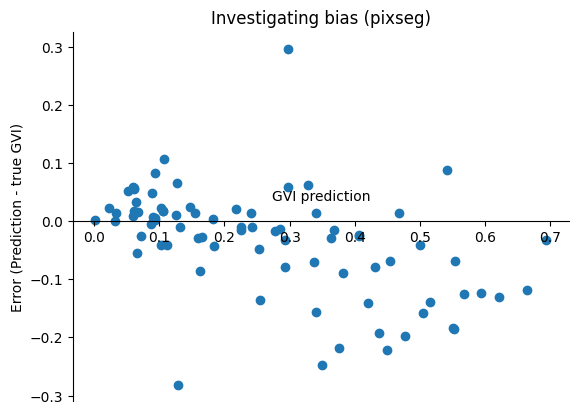

In [15]:
import matplotlib.pyplot as plt
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
ax.scatter(pixseg_prediction['pred'], pixseg_prediction['diff_with_sign'])

# Move the y-axis to x=0
ax.spines['bottom'].set_position(('data', 0))
# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("GVI prediction", labelpad= -40)
ax.set_ylabel("Error (Prediction - true GVI)")
ax.set_title("Investigating bias (pixseg)")

In [16]:
pixseg_prediction.loc[pixseg_prediction['pred'] < pixseg_prediction['gt'], 'estimation'] = 'underestimation'
pixseg_prediction.loc[pixseg_prediction['pred'] == pixseg_prediction['gt'], 'estimation'] = 'accurate estimation'
pixseg_prediction.loc[pixseg_prediction['pred'] > pixseg_prediction['gt'], 'estimation'] = 'overestimation'

In [17]:
pixseg_prediction[['estimation']].value_counts()

estimation     
underestimation    46
overestimation     34
dtype: int64

In [227]:
grouped_df = pd.DataFrame(pixseg_prediction.groupby([bins, 'estimation']).size()).reset_index().rename(columns={0: 'count'})
grouped_df.pred = grouped_df.pred.astype(str)
grouped_df

,pred,estimation,count
0,"(-0.000537, 0.159]",overestimation,29
1,"(-0.000537, 0.159]",underestimation,13
2,"(0.159, 0.318]",overestimation,3
3,"(0.159, 0.318]",underestimation,14
4,"(0.318, 0.478]",overestimation,1
5,"(0.318, 0.478]",underestimation,15
6,"(0.478, 0.637]",overestimation,1
7,"(0.478, 0.637]",underestimation,4


Text(0.5, 1.0, 'Error analysis of GVI prediction predictions by bins (Pixel Segmntation)')

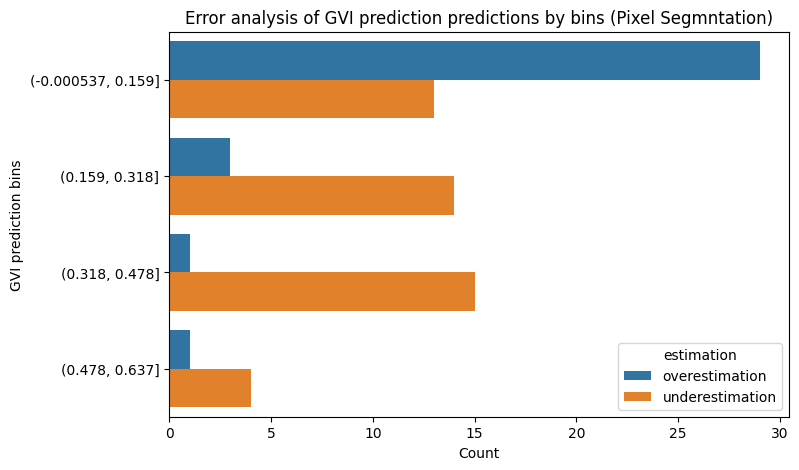

In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you have the grouped_df DataFrame with two levels of index
# grouped_df = ...

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 5))
plt.show = sns.barplot( data=grouped_df, hue='estimation', x='count', y='pred', orient='h', dodge=True, ax=ax)

#ax.set_yticklabels(grouped_df[['pred']].astype(str))
ax.set_xlabel('Count')
ax.set_ylabel('GVI prediction bins')
ax.set_title('Error analysis of GVI prediction predictions by bins (Pixel Segmntation)')
